In [35]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
from netCDF4 import Dataset
import pandas as pd
from scipy import signal
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [36]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [37]:
g = 9.81
depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
times = np.arange(0,720)*600

# bay centers mask
# centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

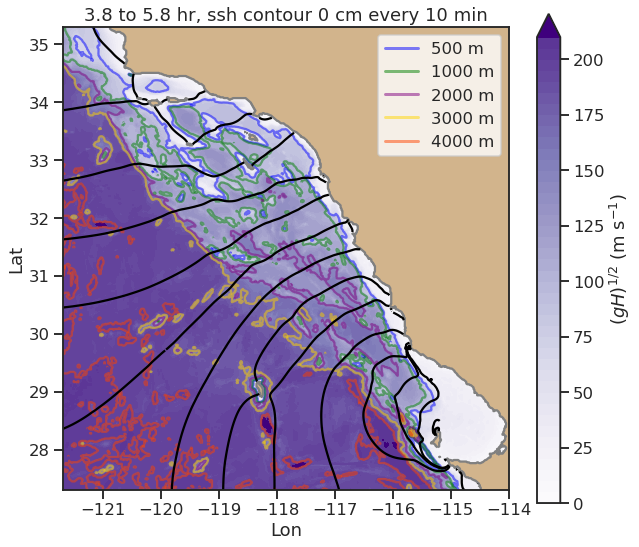

In [38]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.contourf(lon,lat,np.ma.masked_array(np.sqrt(depthSVB*g), mask=mask_depSVB),50,
                 vmin=0, vmax=250, cmap='Purples', extend='max')
cb = plt.colorbar(pc, extend='max',label=r'$(gH)^{1/2}$ (m s$^{-1}$)')

ax.contour(LON,LAT,depthSVB[:,:],levels=[500,1000,2000,3000,4000],
           colors=['blue','green','purple','gold','orangered'], alpha=0.5)
ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.5')

custom_lines = [Line2D([0], [0], color='blue', lw=3, alpha=0.5),
                Line2D([0], [0], color='green', lw=3, alpha=0.5),
                Line2D([0], [0], color='purple', lw=3, alpha=0.5),
               Line2D([0], [0], color='gold', lw=3, alpha=0.5), 
               Line2D([0], [0], color='orangered', lw=3, alpha=0.5)]

ax.legend(custom_lines, ['500 m', '1000 m', '2000 m','3000 m','4000 m'])

col = 'k'

# Before second node apears, contour ssh in the whole domain: 
for tt in range(23, 30):
    ssh = np.ma.masked_array(ds.ETAN[tt,:,:]-ds2.ETAN[tt,:,:], mask=mask[0,:,:])   
    ax.contour(LON,LAT,ssh*100,levels=[0], alpha=1, colors=[col])

lati1 = 200
loni2 = 200
loni3 = 315
lati4 = 300
#ax.axhline(lat[lati1], color='cyan')
#ax.axvline(lon[loni2], color='cyan')
#ax.axvline(lon[loni3], color='red')
#ax.axhline(lat[lati4], color='red')

# Second node appears, only contour 1st node in some parts of the domain: 
for tt in range(30, 33):
    ssh = np.ma.masked_array(ds.ETAN[tt,lati1:,:]-ds2.ETAN[tt,lati1:,:], mask=mask[0,lati1:,:])   
    ax.contour(LON[lati1:,:],LAT[lati1:,:],ssh*100,levels=[0], alpha=1, colors=[col])
    
    ssh = np.ma.masked_array(ds.ETAN[tt,:lati1,:loni2]-ds2.ETAN[tt,:lati1,:loni2], mask=mask[0,:lati1,:loni2])   
    ax.contour(LON[:lati1,:loni2],LAT[:lati1,:loni2],ssh*100,levels=[0], alpha=1, colors=[col])
    
for tt in range(33,36):
    ssh = np.ma.masked_array(ds.ETAN[tt,lati4:,:loni3]-ds2.ETAN[tt,lati4:,:loni3], mask=mask[0,lati4:,:loni3])   
    ax.contour(LON[lati4:,:loni3],LAT[lati4:,:loni3],ssh*100,levels=[0], alpha=1, colors=[col])
    
ax.set_title('3.8 to 5.8 hr, ssh contour 0 cm every 10 min')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(238.3-360, 246-360)
ax.set_ylim(27.3,35.3)
ax.set_aspect(1)

In [39]:
# c2/c1 = k1/k2 (snell) between wave over 3000 m depth and 2000 m depth
np.sqrt(2000*g)/np.sqrt(3000*g)

0.8164965809277261

### Approx wavelength

In [40]:
# Distance (haversine)
def distance(lat1,lon1,lat2,lon2):
    '''Distance using Haversine formula in km'''
    r = 6371 #radius of Earth (KM)
    p = np.pi/180  #Pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    d = 2 * r * np.arcsin(np.sqrt(a)) #2*R*asin In km
    return d

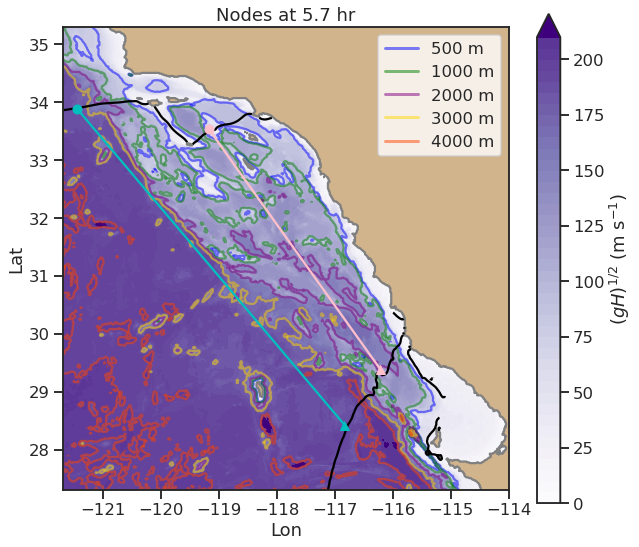

the approx wavelength in the deeper part is 1493.110 km
the approx wavelength in the 2000 m part is 1080.179 km


In [48]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.contourf(lon,lat,np.ma.masked_array(np.sqrt(depthSVB*g), mask=mask_depSVB),50,
                 vmin=0, vmax=250, cmap='Purples', extend='max')
cb = plt.colorbar(pc, extend='max',label=r'$(gH)^{1/2}$ (m s$^{-1}$)')

ax.contour(LON,LAT,depthSVB[:,:],levels=[500,1000,2000,3000,4000],
           colors=['blue','green','purple','gold','orangered'], alpha=0.5)
ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.5')

custom_lines = [Line2D([0], [0], color='blue', lw=3, alpha=0.5),
                Line2D([0], [0], color='green', lw=3, alpha=0.5),
                Line2D([0], [0], color='purple', lw=3, alpha=0.5),
               Line2D([0], [0], color='gold', lw=3, alpha=0.5), 
               Line2D([0], [0], color='orangered', lw=3, alpha=0.5)]

ax.legend(custom_lines, ['500 m', '1000 m', '2000 m','3000 m','4000 m'])

col = 'k'
tt = 34
# plot 2 nodes
ssh = np.ma.masked_array(ds.ETAN[tt,:,:]-ds2.ETAN[tt,:,:], mask=mask[0,:,:])   
ax.contour(LON,LAT,ssh*100,levels=[0], alpha=1, colors=[col])

loni1 = 330
loni2 = 35
lati1 = 105
lati2 = 505

loni1b = 370
loni2b = 180
lati1b = 175
lati2b = 480

ax.plot(lon[loni1], lat[lati1], 'c^')
ax.plot(lon[loni2], lat[lati2], 'co')
ax.plot([lon[loni2],lon[loni1]], [lat[lati2],lat[lati1]], 'c')

ax.plot(lon[loni1b], lat[lati1b], '^', color='pink')
ax.plot(lon[loni2b], lat[lati2b], 'o', color='pink')
ax.plot([lon[loni2b],lon[loni1b]], [lat[lati2b],lat[lati1b]], color='pink')

ax.set_title('Nodes at %1.1f hr' %(times[tt]/3600))
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(238.3-360, 246-360)
ax.set_ylim(27.3,35.3)
ax.set_aspect(1)
plt.show()

wavelength = 2*distance(lat[lati1],lon[loni1],lat[lati2],lon[loni2])
wavelengthb = 2*distance(lat[lati1b],lon[loni1b],lat[lati2b],lon[loni2b])

print('the approx wavelength in the deeper part is %1.3f km' %wavelength)
print('the approx wavelength in the 2000 m part is %1.3f km' %wavelengthb)

In [49]:
# c2/c1 = k1/k2 (snell) between wave over 3000 m depth and 2000 m depth
# Then k2 is about:
c2c1 = np.sqrt(2000*g)/np.sqrt(3000*g)
k1 = 2*np.pi/wavelength
k2 = k1/c2c1
print('c2/c1 =%1.3f, k1=%1.3e, k2=%1.3e' %(c2c1,k1,k2))

c2/c1 =0.816, k1=4.208e-03, k2=5.154e-03


In [50]:
wavelength2 = 2*np.pi/k2

print('lambda1 = %1.2f km, lambda2=%1.1f km' %(wavelength, wavelength2))

lambda1 = 1493.11 km, lambda2=1219.1 km


In [51]:
# c2/c1 = k1/k2 (snell) between wave over 3000 m depth and 2000 m depth
# Then k2 is about:
c3c2 = np.sqrt(1000*g)/np.sqrt(2000*g)
k3 = k2/c3c2
print('c3/c2 =%1.3f, k2=%1.3e, k3=%1.3e' %(c3c2,k2,k3))

c3/c2 =0.707, k2=5.154e-03, k3=7.289e-03


In [52]:
wavelength3 = 2*np.pi/k3

print('lambda3 = %1.2f km' %(wavelength3))

lambda3 = 862.05 km


### Wave speed

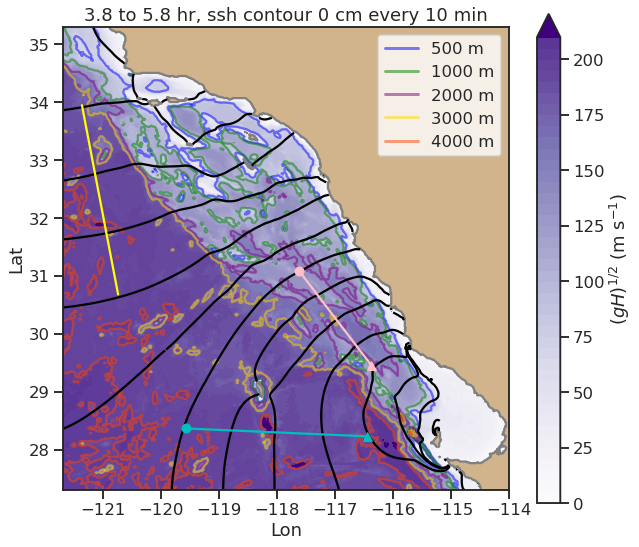

In [53]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.contourf(lon,lat,np.ma.masked_array(np.sqrt(depthSVB*g), mask=mask_depSVB),50,
                 vmin=0, vmax=250, cmap='Purples', extend='max')
cb = plt.colorbar(pc, extend='max',label=r'$(gH)^{1/2}$ (m s$^{-1}$)')

ax.contour(LON,LAT,depthSVB[:,:],levels=[500,1000,2000,3000,4000],
           colors=['blue','green','purple','gold','orangered'], alpha=0.5)
ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.5')

custom_lines = [Line2D([0], [0], color='blue', lw=3, alpha=0.5),
                Line2D([0], [0], color='green', lw=3, alpha=0.5),
                Line2D([0], [0], color='purple', lw=3, alpha=0.5),
               Line2D([0], [0], color='gold', lw=3, alpha=0.5), 
               Line2D([0], [0], color='orangered', lw=3, alpha=0.5)]

ax.legend(custom_lines, ['500 m', '1000 m', '2000 m','3000 m','4000 m'])

col = 'k'

# Before second node apears, contour ssh in the whole domain: 
for tt in range(23, 30):
    ssh = np.ma.masked_array(ds.ETAN[tt,:,:]-ds2.ETAN[tt,:,:], mask=mask[0,:,:])   
    ax.contour(LON,LAT,ssh*100,levels=[0], alpha=1, colors=[col])

lati1 = 200
loni2 = 200
loni3 = 315
lati4 = 300

# Second node appears, only contour 1st node in some parts of the domain: 
for tt in range(30, 33):
    ssh = np.ma.masked_array(ds.ETAN[tt,lati1:,:]-ds2.ETAN[tt,lati1:,:], mask=mask[0,lati1:,:])   
    ax.contour(LON[lati1:,:],LAT[lati1:,:],ssh*100,levels=[0], alpha=1, colors=[col])
    
    ssh = np.ma.masked_array(ds.ETAN[tt,:lati1,:loni2]-ds2.ETAN[tt,:lati1,:loni2], mask=mask[0,:lati1,:loni2])   
    ax.contour(LON[:lati1,:loni2],LAT[:lati1,:loni2],ssh*100,levels=[0], alpha=1, colors=[col])
    
for tt in range(33,36):
    ssh = np.ma.masked_array(ds.ETAN[tt,lati4:,:loni3]-ds2.ETAN[tt,lati4:,:loni3], mask=mask[0,lati4:,:loni3])   
    ax.contour(LON[lati4:,:loni3],LAT[lati4:,:loni3],ssh*100,levels=[0], alpha=1, colors=[col])
    
loni1 = 355
loni2 = 155
lati1 = 90
lati2 = 100

loni1b = 360
loni2b = 280
lati1b = 180
lati2b = 300

loni1c = 80
loni2c = 40
lati1c = 270
lati2c = 510

ax.plot(lon[loni1], lat[lati1], 'c^')
ax.plot(lon[loni2], lat[lati2], 'co')
ax.plot([lon[loni2],lon[loni1]], [lat[lati2],lat[lati1]], 'c')

ax.plot(lon[loni1b], lat[lati1b], '^', color='pink')
ax.plot(lon[loni2b], lat[lati2b], 'o', color='pink')
ax.plot([lon[loni2b],lon[loni1b]], [lat[lati2b],lat[lati1b]], color='pink')

ax.plot([lon[loni2c],lon[loni1c]], [lat[lati2c],lat[lati1c]], color='yellow')

dista = distance(lat[lati1],lon[loni1],lat[lati2],lon[loni2])
distb = distance(lat[lati1b],lon[loni1b],lat[lati2b],lon[loni2b])
distc = distance(lat[lati1c],lon[loni1c],lat[lati2c],lon[loni2c])

ax.set_title('3.8 to 5.8 hr, ssh contour 0 cm every 10 min')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(238.3-360, 246-360)
ax.set_ylim(27.3,35.3)
ax.set_aspect(1)

In [47]:
print('the approx wavespeed in the cyan transect is %1.3f m/s (%1.3f km/h)' 
      %((dista*1e3)/(40*60),3.6*(dista*1e3)/(40*60)))
print('the approx wavespeed in the pink transect is %1.3f m/s (%1.3f km/h)' 
      %((distb*1e3)/(40*60),3.6*(distb*1e3)/(40*60)))
print('the approx wavespeed in the yellow transect is %1.3f m/s (%1.3f km/h)' 
      %((distc*1e3)/(30*60),3.6*(distc*1e3)/(30*60)))

the approx wavespeed in the cyan transect is 127.430 m/s (458.747 km/h)
the approx wavespeed in the pink transect is 90.613 m/s (326.206 km/h)
the approx wavespeed in the yellow transect is 204.247 m/s (735.289 km/h)
